In [2]:
# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# for data processing
from sklearn.preprocessing import StandardScaler

# for saving loading
import pickle

# for model insights
from sklearn.model_selection import train_test_split
import shap

# for data insights
from sklearn.cluster import k_means

# for clean notebook presentation
from IPython.display import clear_output

### Summary

This notebook will use our model to extract feature importance, and other tools for further data insight.

### Load Model

In [3]:
with open('./pkl/xgb_best.pkl', 'rb') as file:
    model = pickle.load(file)

### Load Data

In [4]:
# reload unscaled data
model_data = pd.read_csv('./data/HR_data_for_model.csv', index_col=0)

# seperate inputs and targets
X = model_data.drop(columns=['left'])
y = model_data['left']

<br><br>
### Insight 1: Feature Importance  

##### Question: What factors matter most when predicting employee churn?

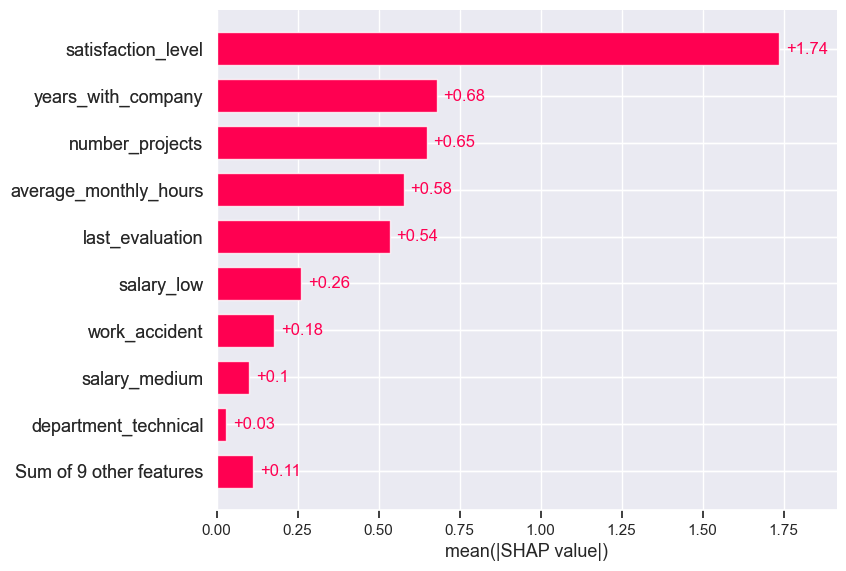

In [16]:
# By extracting shaply values using our model, we can see what features affect whether people leave or stay.

# extract stratified sample (to save on processing time)
X500, _, _, _ = train_test_split(X, y, train_size=500, stratify=y)

explainer   = shap.Explainer(model, X500)
shap_values = explainer(X)

clear_output()
shap.plots.bar(shap_values)

##### Answer: satisfaction_level is the #1 predictive factor for employee churn, followed by how much they work (hours & projects), how long they've been with the company, and how good they are doing.


<br><br><br><br>

### Insight 2: People Groups

##### Question: Are there categories of leave and stay employees?

In [17]:
# Using kmeans clustering we will attempt to identify "categories" of stay and leave employees.

# scale data for kmeans
features = ['satisfaction_level', 'number_projects', 'average_monthly_hours', 'last_evaluation', 'years_with_company']
X_kmeans = StandardScaler().fit_transform(X[features])

# test for cluster sizes {1 ... 10}
results = {}
for outcome, label in zip(['stay', 'leave'], [0, 1]):
    results[outcome] = []
    for n in range(1, 10):
        centroid, labels, inertia = k_means(X_kmeans[y==label], n, n_init=10)
        results[outcome].append(inertia)

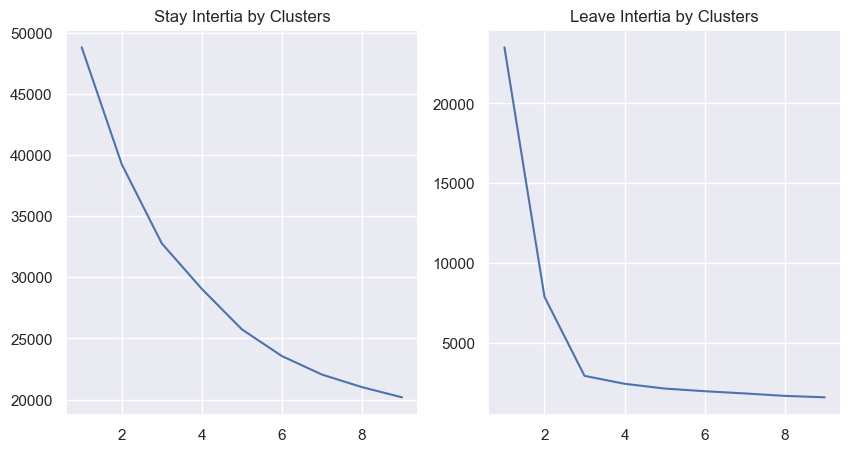

In [65]:
# plot
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10,5))

ax[0].plot(range(1, 10), results['stay'])
ax[0].set(title='Stay Intertia by Clusters')

ax[1].plot(range(1, 10), results['leave'])
ax[1].set(title='Leave Intertia by Clusters')

plt.show()

##### Answer: While there are no obvious clusters of stay employees, there are 3 distinct clusters of leave empolyees.

<br><br><br><br>

### Insight 3: Analyze People Groups

##### Question: What are the characteristics of these 3 leave groups?

In [81]:
stay_centroids,   stay_labels, _ = k_means(X_kmeans[y==0], 1, random_state=42, n_init=10)
leave_centroids, leave_labels, _ = k_means(X_kmeans[y==1], 3, random_state=42, n_init=10)

X.loc[y==0, 'labels'] = stay_labels
X.loc[y==1, 'labels'] = leave_labels + 1
X['labels'] = X['labels'].astype('category')

def plot_people_group(label_num, label_title):
    sns.set_theme()
    fig, ax = plt.subplots(1, 5, figsize=(11, 4))
    for i in range(5):
        subset = (X['labels'] == 0) | (X['labels'] == label_num)
        X_plot = X[subset].copy()
        X_plot['labels'] = X[subset]['labels'].astype(int).astype('category')
        count = (X_plot['labels'] == label_num).sum()
        sns.boxplot(data=X_plot, y=features[i], x='labels', ax=ax[i], palette=['C2', 'C3'], showfliers=False)
        ax[i].set(xlabel=None)
        ax[i].set_xticks(ticks=[0, 1], labels=['Healthy Employee', label_title], rotation=90)
        
    plt.suptitle(f'{label_title} ({count} employees)')
    plt.subplots_adjust(wspace=.7)
    plt.show()

##### Answer:  By comparing each leave group against the stay group, distinct characteristics will emerge.

<br><br><br><br>

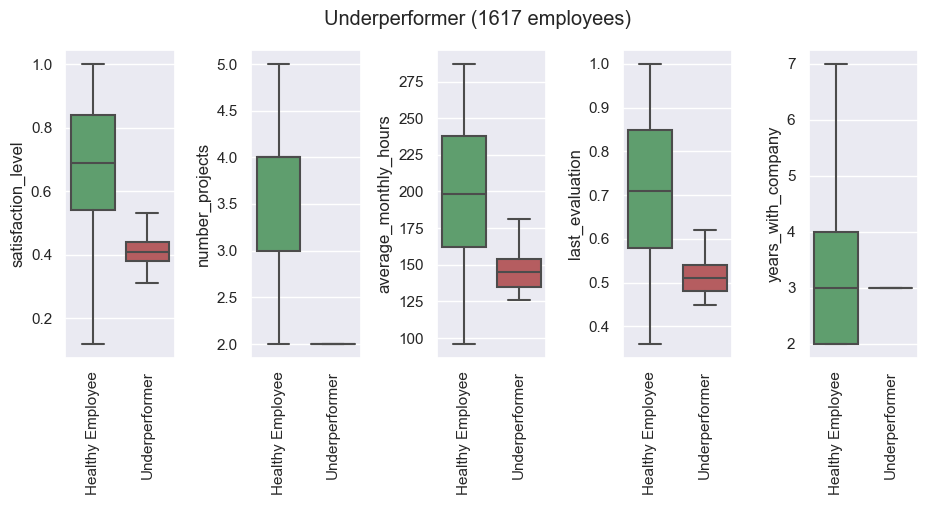

In [83]:
plot_people_group(1, 'Underperformer')

##### Leave Group 1: The Underperformer
- Low Satisfaction
- Low Projects
- Low Hours
- Low Evaluation

<br><br>

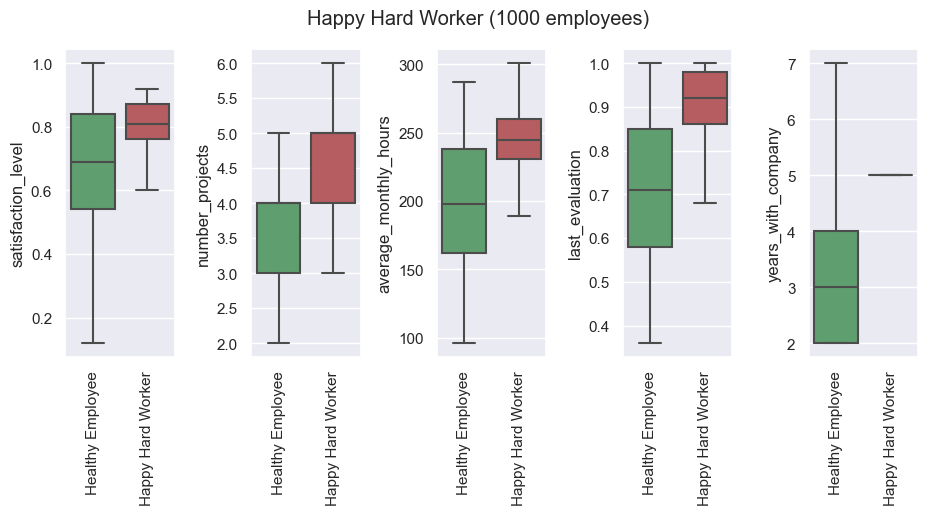

In [85]:
plot_people_group(2, 'Happy Hard Worker')

##### Leave Group 2: The Happy Hard Worker
- High Satisfaction
- High Projects
- High Hours
- High Evaluation

<br><br>

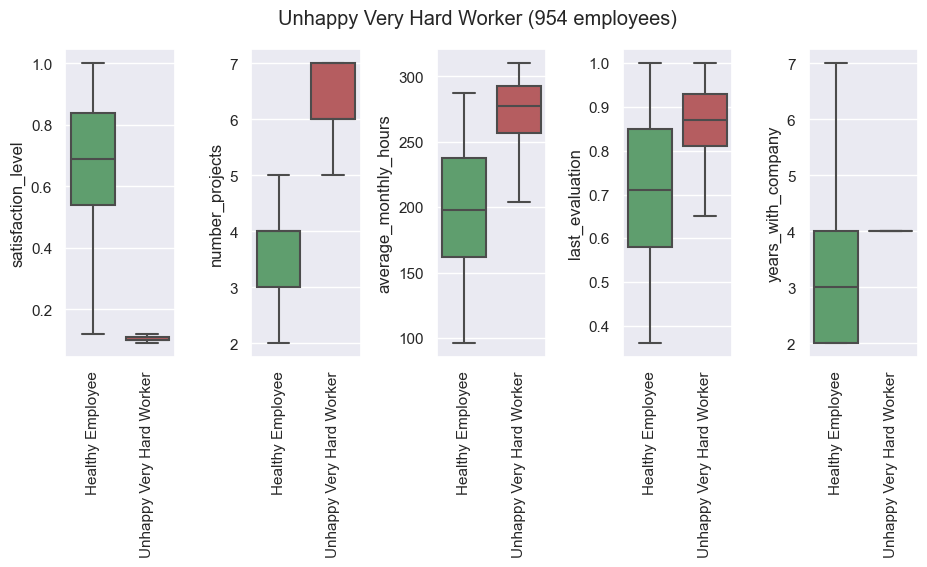

In [86]:
plot_people_group(3, 'Unhappy Very Hard Worker')

##### Leave Group 3: Unhappy Very Hard Worker
- Very Low Satisfaction
- Very High Projects
- Very High Hours
- High Evaluation

<br><br>

### Insight 4: Number of Projects

##### Question: How does the number of projects relate to employee retention?

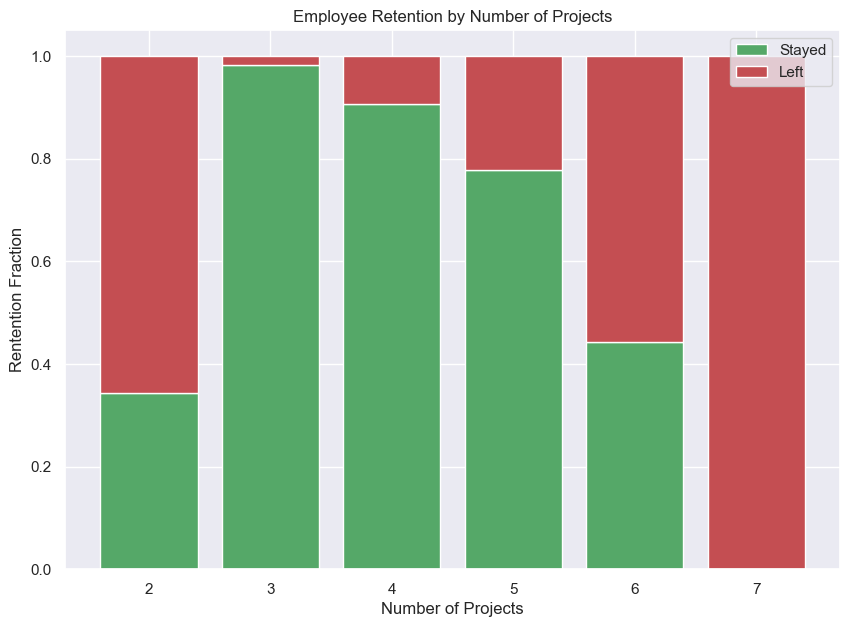

In [70]:
by_n_projects = model_data.groupby('number_projects')[['left']].mean()
by_n_projects['stay'] = 1 - by_n_projects['left']

fig = plt.figure(figsize=(10, 7))
plt.bar(by_n_projects.index, by_n_projects['stay'], color='C2', label='Stayed')
plt.bar(by_n_projects.index, by_n_projects['left'], bottom=by_n_projects['stay'], color='C3', label='Left')
plt.title('Employee Retention by Number of Projects')
plt.xlabel('Number of Projects')
plt.ylabel('Rentention Fraction')
plt.legend()
plt.show()

##### Answer: The ideal number of projects is 3.  Increaseing or decreasing from this correlates with increased churn.

<br><br><br><br>

### Insight 5: Hours

##### Question: How does hours worked correlate to employee rentension?

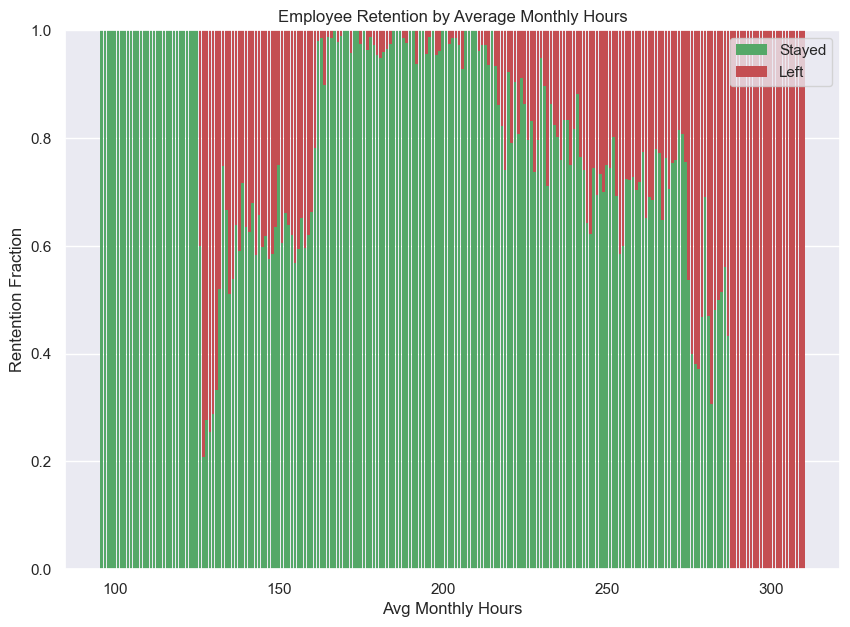

In [72]:
by_hours = model_data.groupby('average_monthly_hours')[['left']].mean()
by_hours['stay'] = 1 - by_hours['left']

fig = plt.figure(figsize=(10, 7))
plt.bar(by_hours.index, by_hours['stay'], color='C2', label='Stayed', linewidth=0)
plt.bar(by_hours.index, by_hours['left'], bottom=by_hours['stay'], color='C3', label='Left', linewidth=0)
plt.title('Employee Retention by Average Monthly Hours')
plt.xlabel('Avg Monthly Hours')
plt.ylabel('Rentention Fraction')
plt.legend()
plt.show()

##### Answer: There are two ideal ranges, presumably for part-time and full-time.
- Part-time: 24-31 hrs a week correlates with 100% employee retention.
- Full-time: 40-54 hrs a week correlates with 99% employee retention.

*employees who exceed 72+hrs a week correlate with a 100% churn rate*

<br><br><br><br>

### Summary of Findings:


There is an ideal workload.  As employees diverge from this norm, their correlation with churn increases.

<br><br><br><br>

### Next Step: [Solution Analysis](4_Solution_Analysis.ipynb)